In [162]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize


pd.set_option('display.max_columns', None)

# Functions

In [71]:
def freq( df , var ):

    if type(var) != list:
        var = [var]
    for v in var:
        aux = df[v].value_counts().to_frame().rename(columns={'count':'FA'})
        aux['FR'] = aux['FA'] / aux['FA'].sum()
        aux[['FAA','FRA']] = aux.apply( np.cumsum )
        print(f"La variable: {v}")
        display(aux)
        print('\n')
        
def norm( df, v , umbral ):
    aux = df[v].value_counts(True).to_frame()
    aux[f'n_{v}'] = np.where( aux['proportion'] < umbral , 'SMALL_CAT' , aux.index )
    
    moda = aux.head()[f'n_{v}'].values[0]
    
    if aux.loc[ aux[f'n_{v}'] == 'SMALL_CAT']['proportion'].sum() < umbral:
        aux[f'n_{v}'].replace({ 'SMALL_CAT':moda },inplace=True)
        
    #aux.drop(v,axis=1, inplace=True)
    aux.reset_index(inplace=True)
    
    return df.merge( aux , left_on=[v] , right_on=[v] , how='inner' ).drop('proportion',axis=1)

# Data

In [72]:
df_mat = pd.read_csv('student-mat.csv', sep=';')
df_por = pd.read_csv('student-por.csv', sep=';')

In [73]:
df_mat.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


In [74]:
df_mat.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [75]:
df_por.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


In [76]:
df_por.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


# Data Cleaning

## Missings

In [77]:
df_por.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [78]:
df_mat.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

# EDA

In [79]:
for col in df_por.columns:
    df_por[col] = df_por[col].astype(str)
for col in df_mat.columns:
    df_mat[col] = df_mat[col].astype(str)

In [80]:
for col in df_por.columns:
    print(df_por[col].value_counts())

school
GP    423
MS    226
Name: count, dtype: int64
sex
F    383
M    266
Name: count, dtype: int64
age
17    179
16    177
18    140
15    112
19     32
20      6
21      2
22      1
Name: count, dtype: int64
address
U    452
R    197
Name: count, dtype: int64
famsize
GT3    457
LE3    192
Name: count, dtype: int64
Pstatus
T    569
A     80
Name: count, dtype: int64
Medu
2    186
4    175
1    143
3    139
0      6
Name: count, dtype: int64
Fedu
2    209
1    174
3    131
4    128
0      7
Name: count, dtype: int64
Mjob
other       258
services    136
at_home     135
teacher      72
health       48
Name: count, dtype: int64
Fjob
other       367
services    181
at_home      42
teacher      36
health       23
Name: count, dtype: int64
reason
course        285
home          149
reputation    143
other          72
Name: count, dtype: int64
guardian
mother    455
father    153
other      41
Name: count, dtype: int64
traveltime
1    366
2    213
3     54
4     16
Name: count, dtype: int64


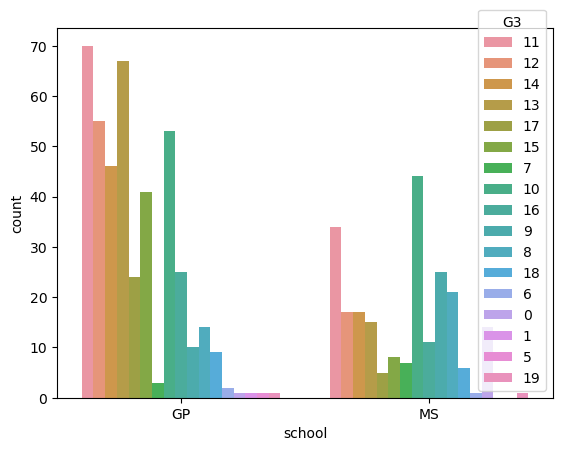

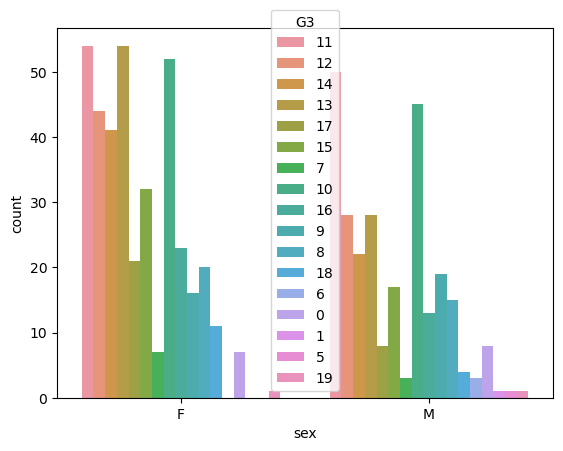

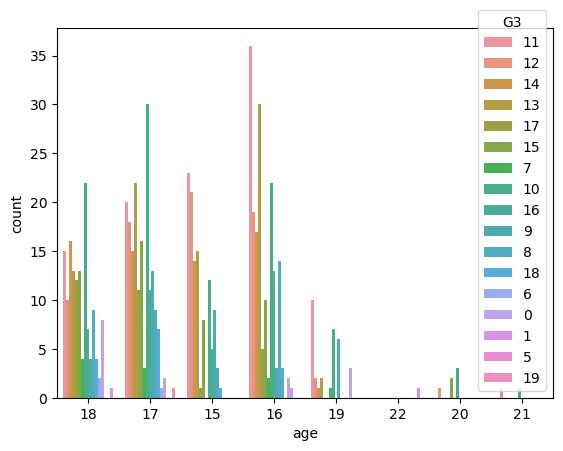

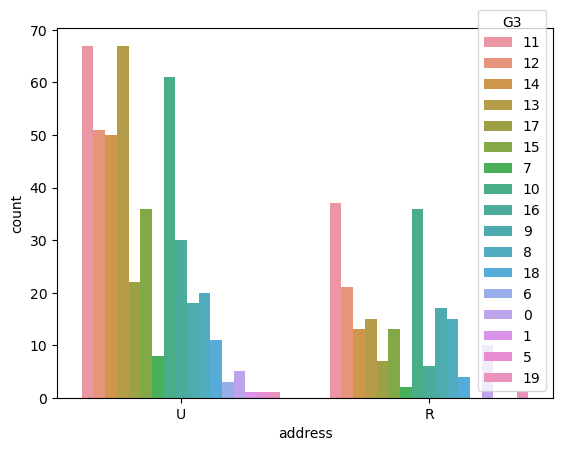

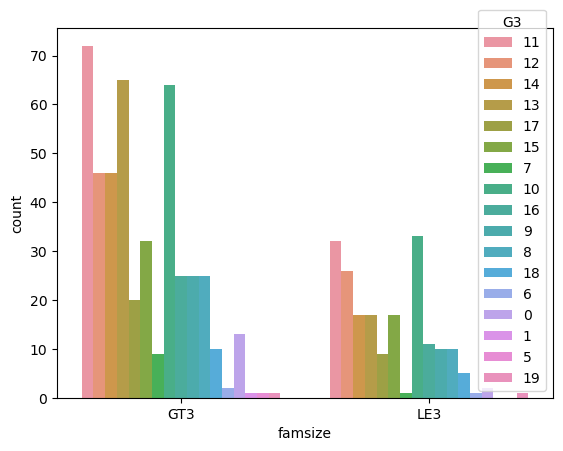

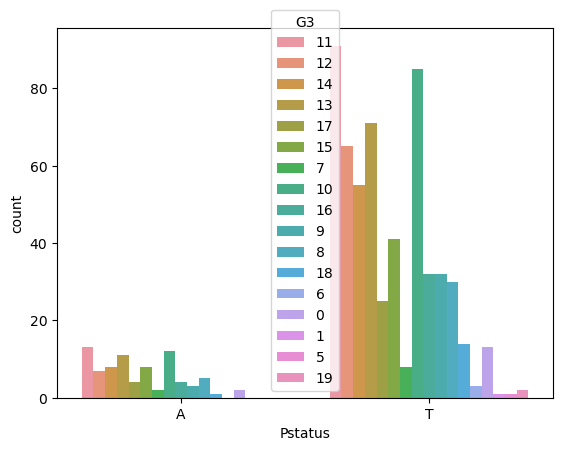

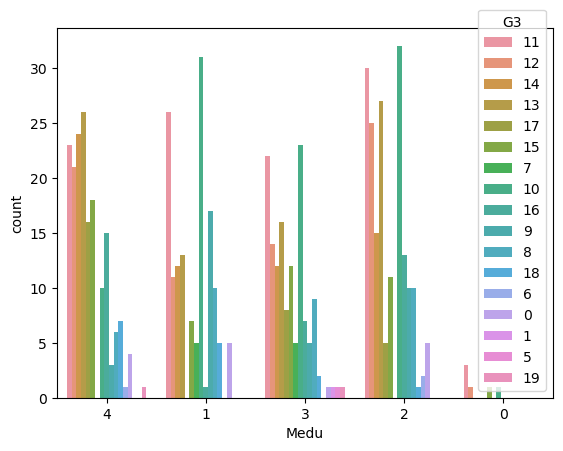

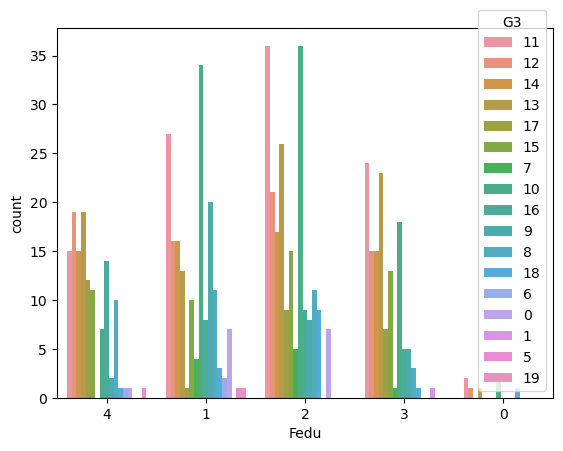

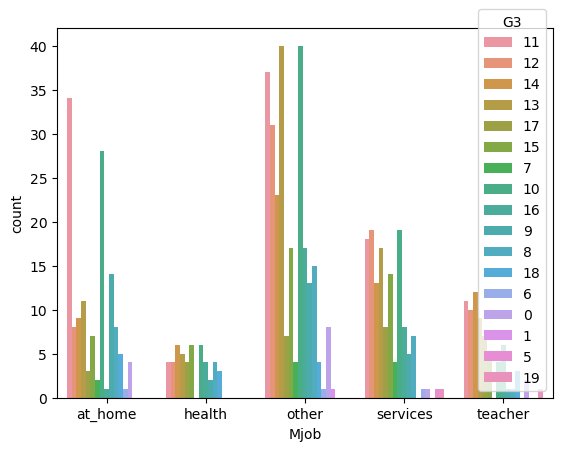

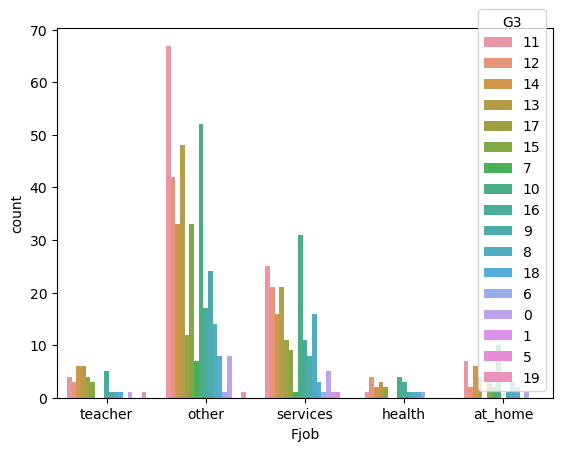

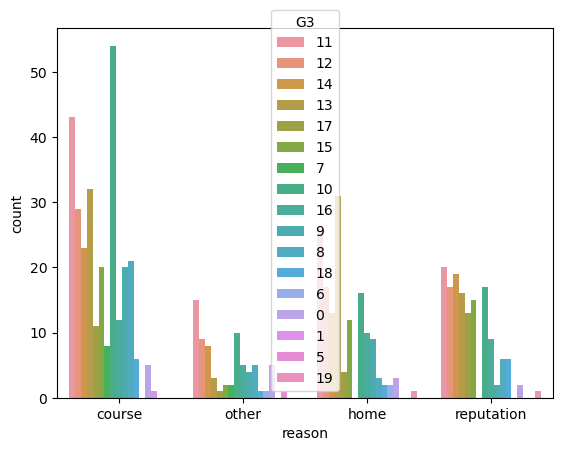

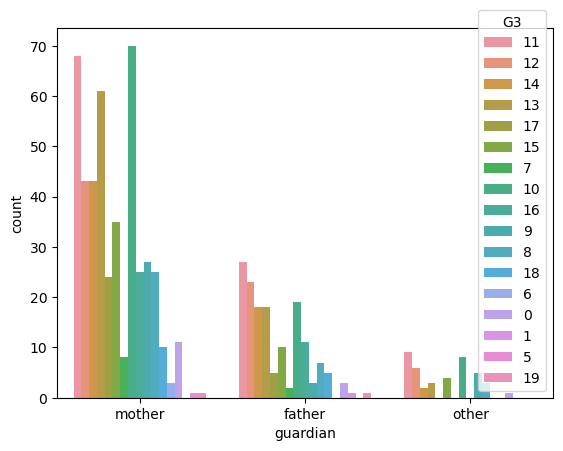

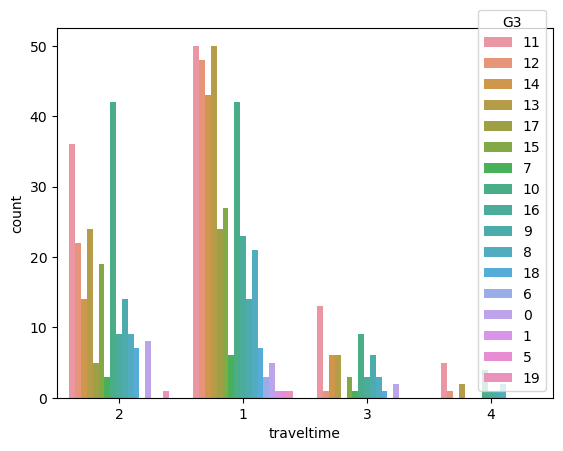

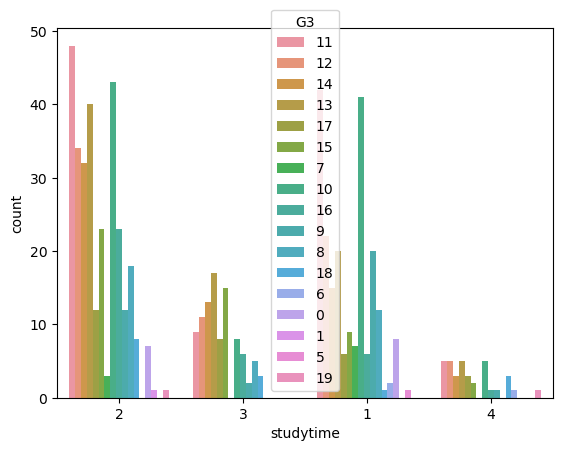

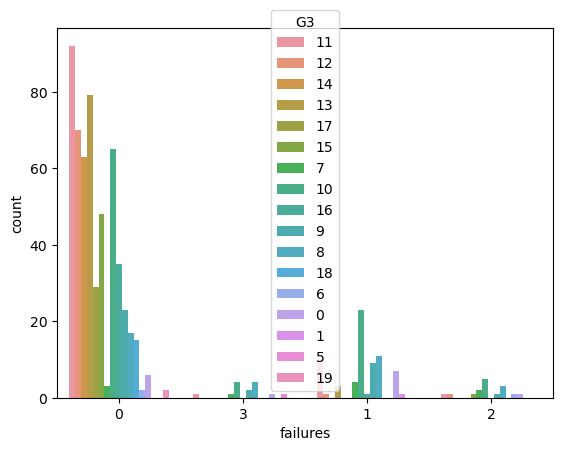

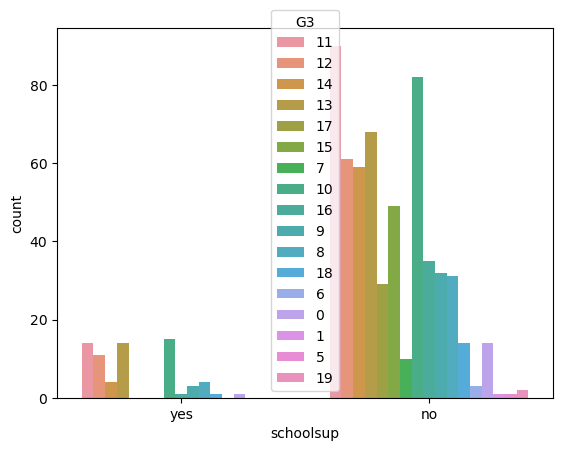

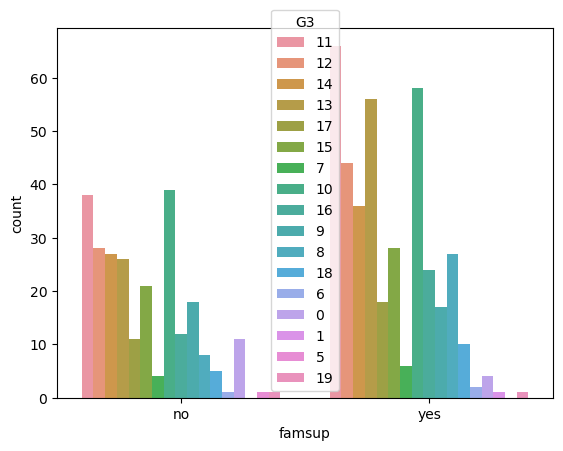

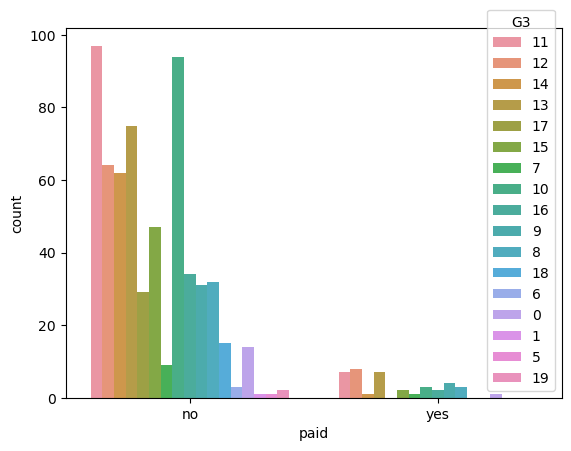

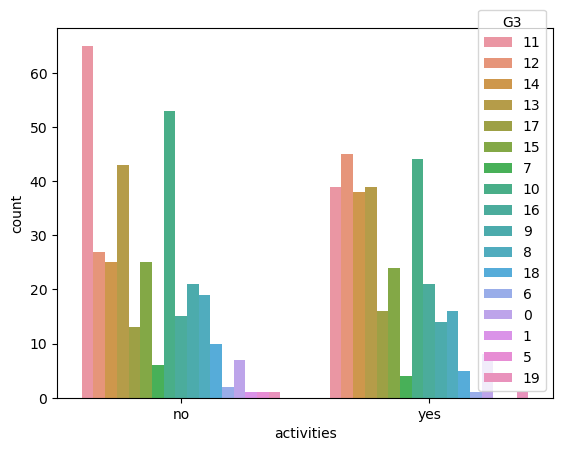

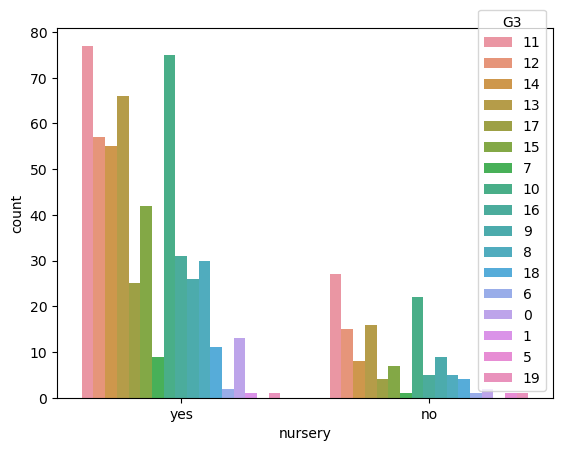

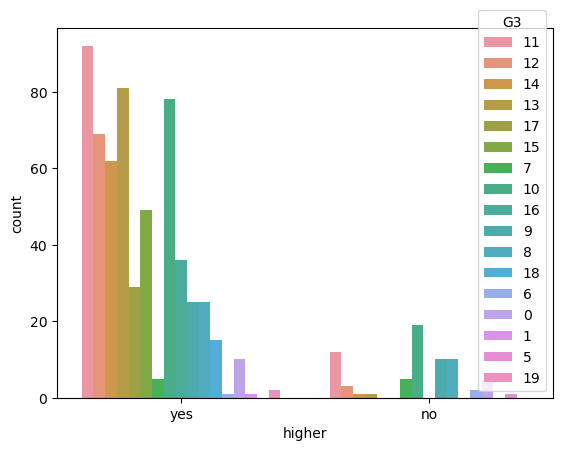

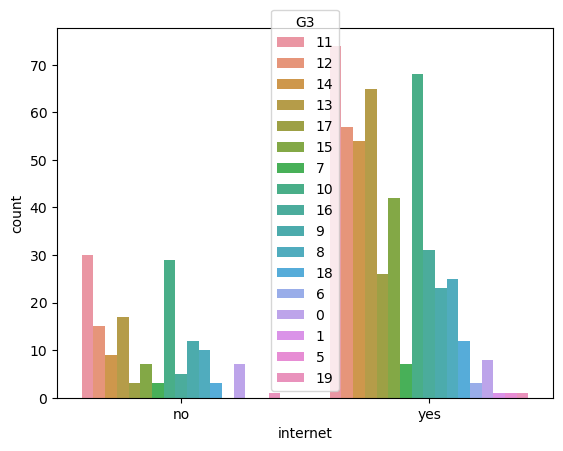

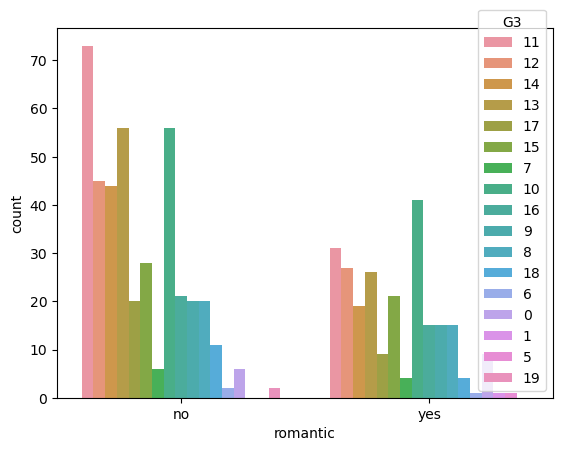

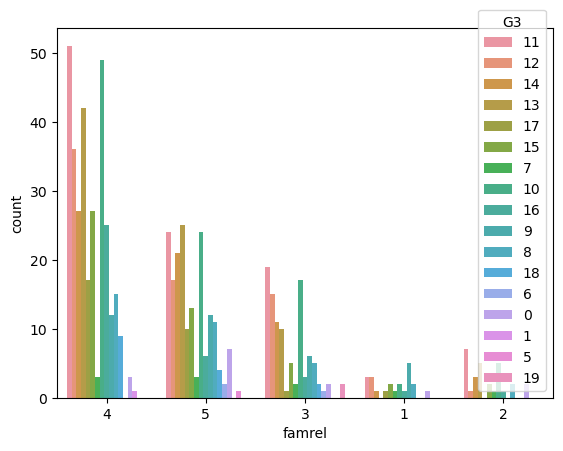

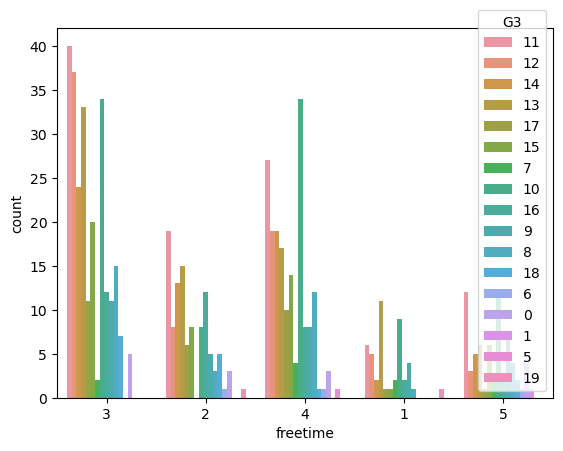

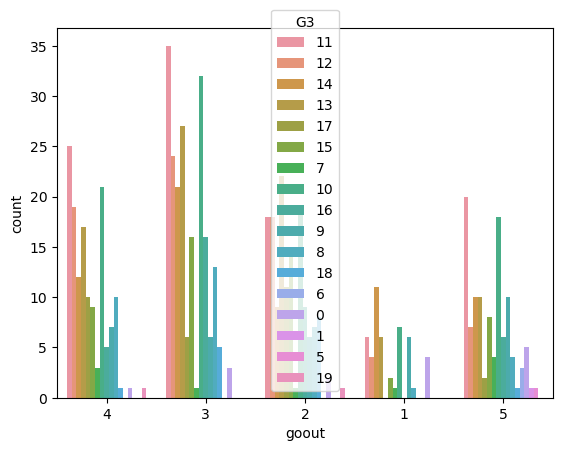

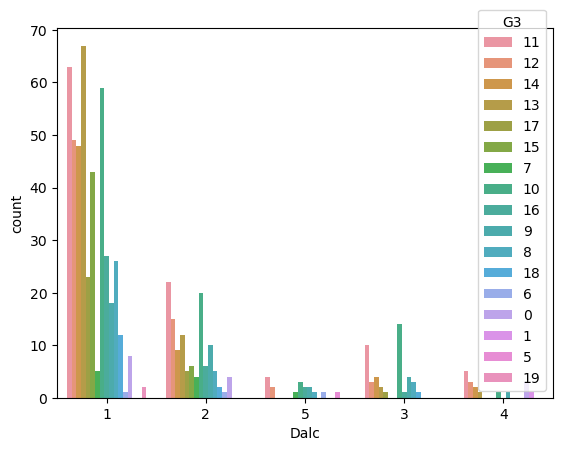

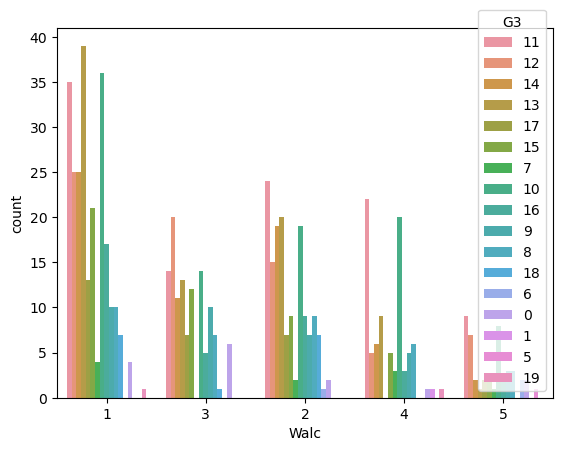

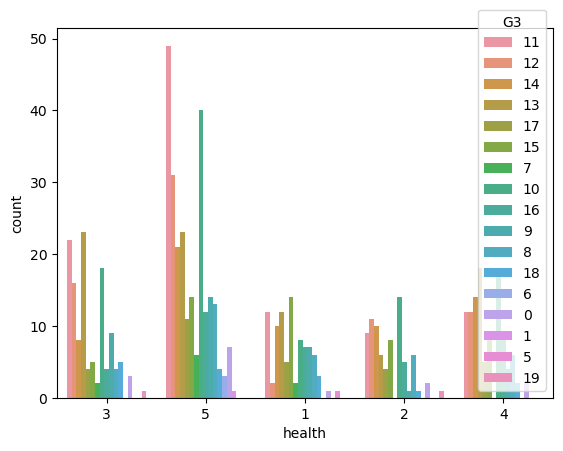

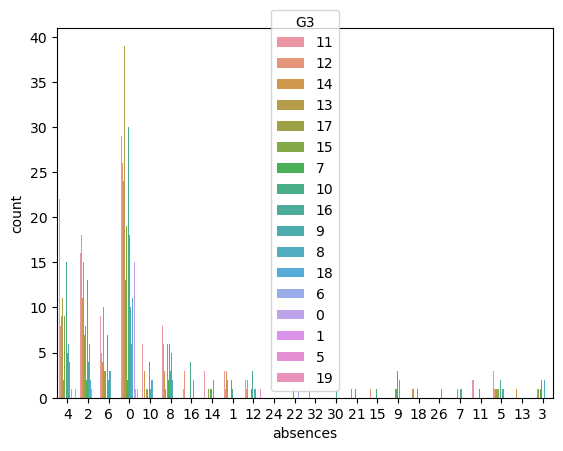

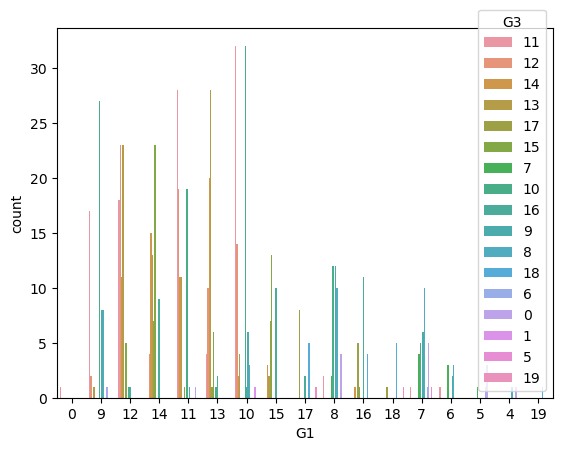

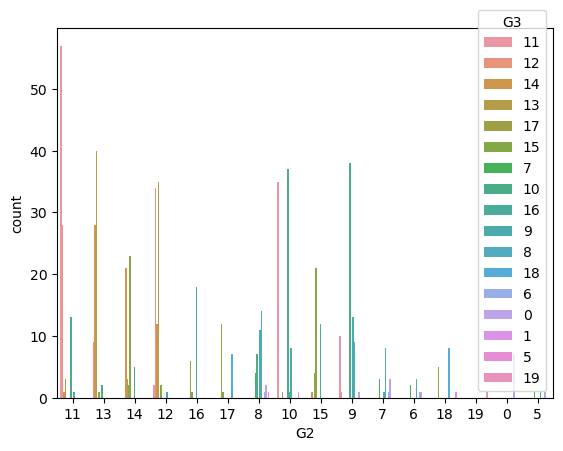

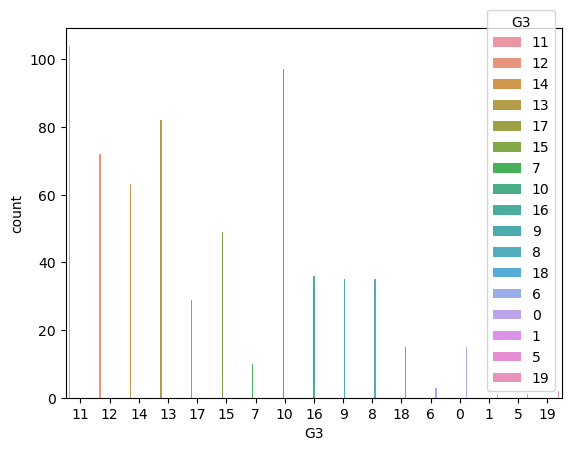

In [81]:
for column in df_por.columns:
    sns.countplot(x=column, hue='G3', data=df_por)
    plt.show()

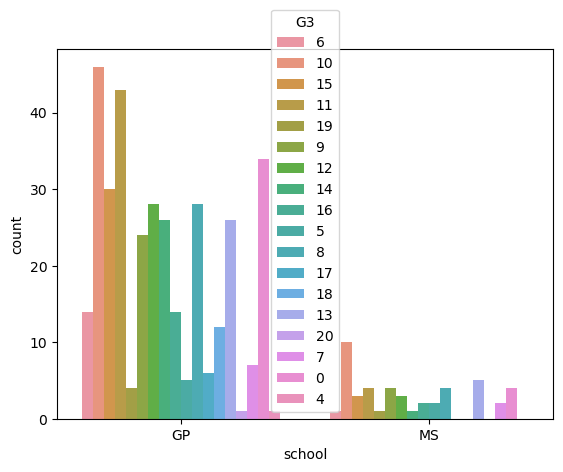

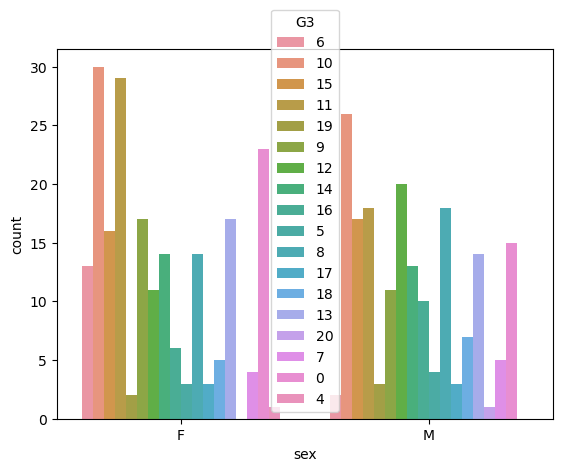

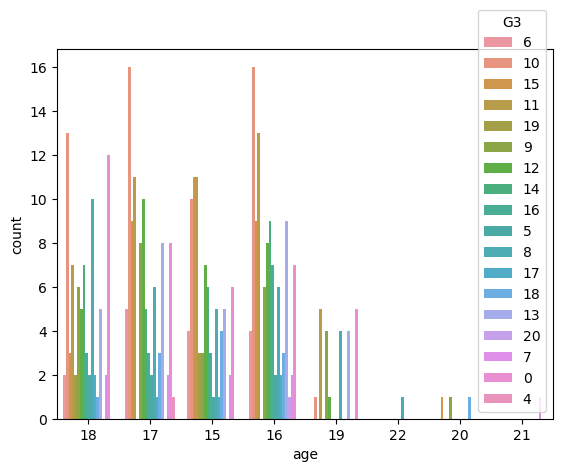

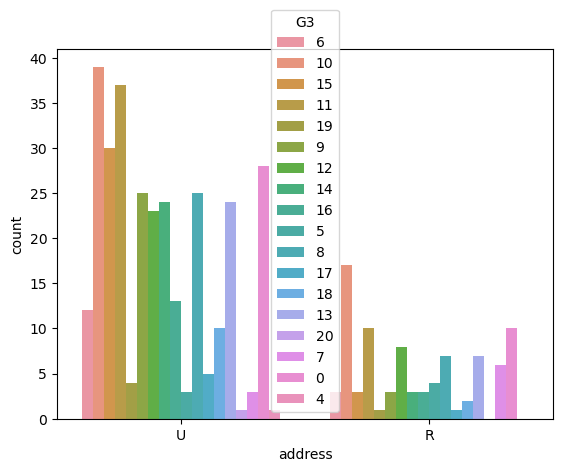

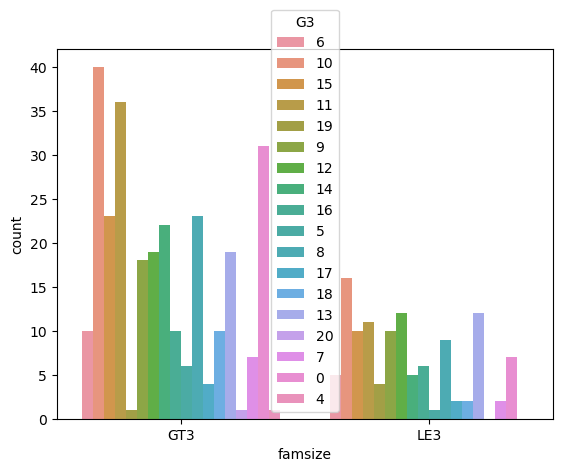

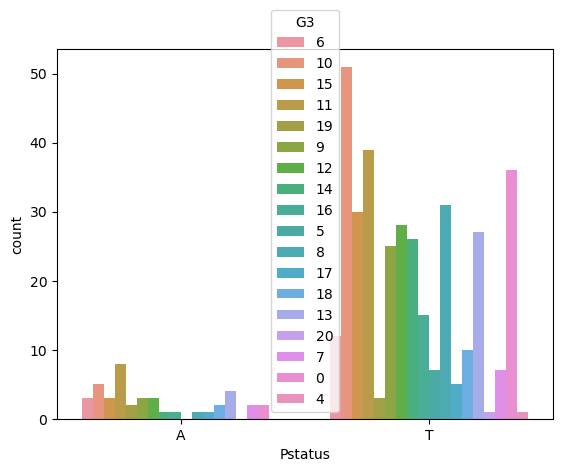

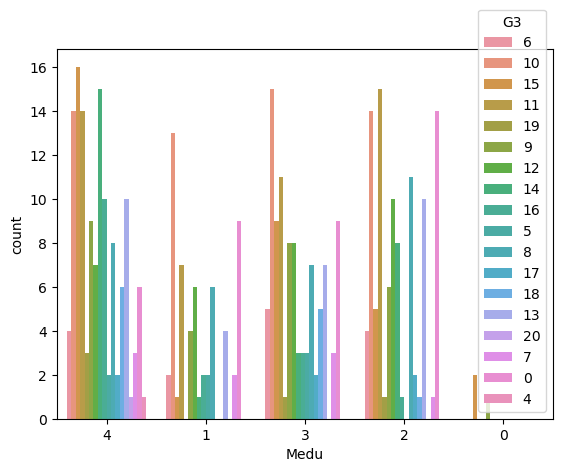

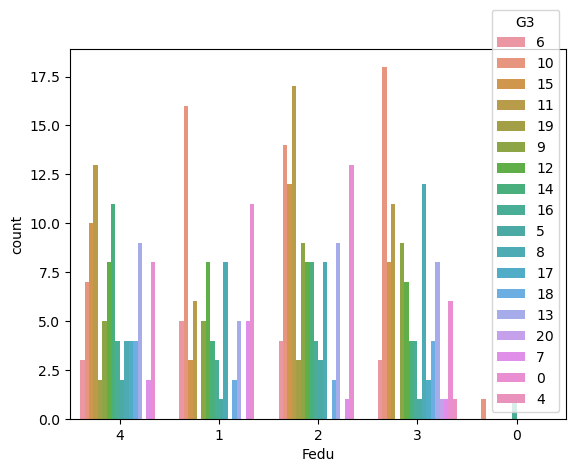

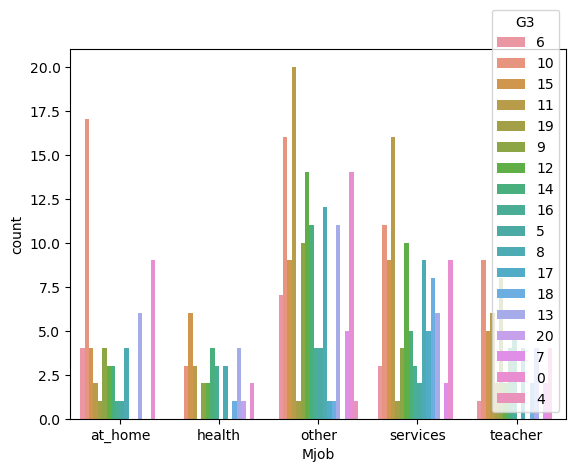

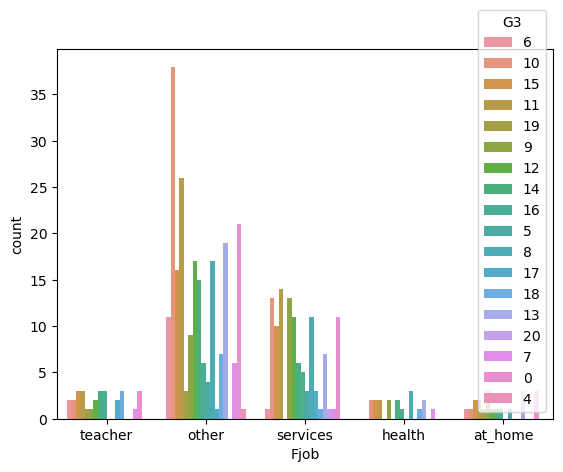

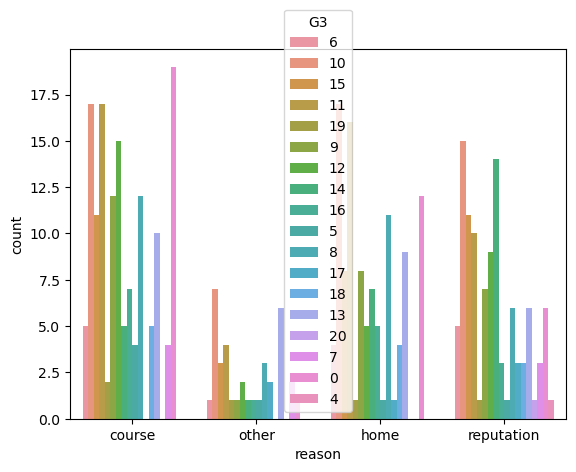

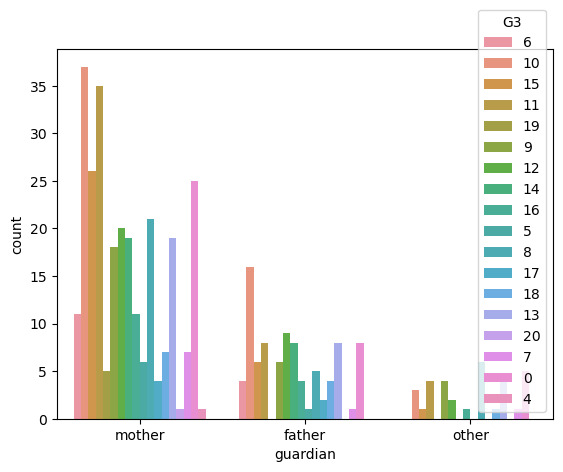

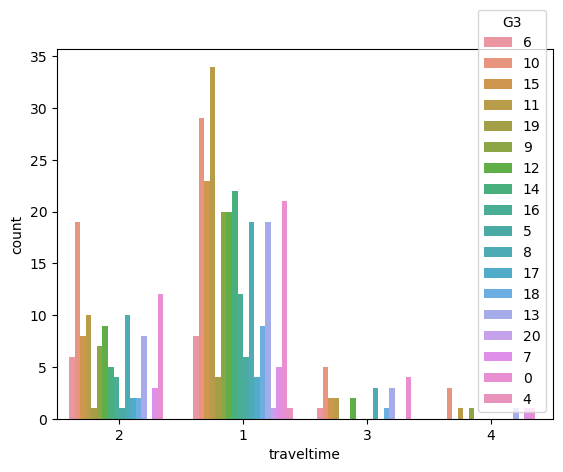

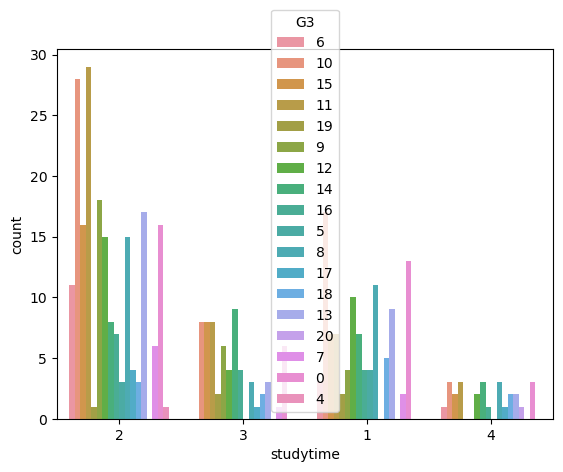

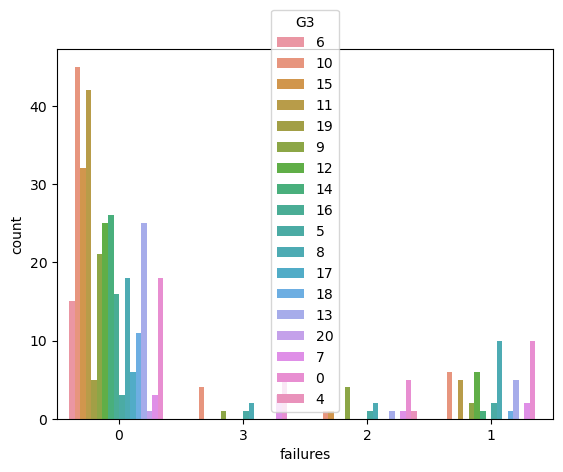

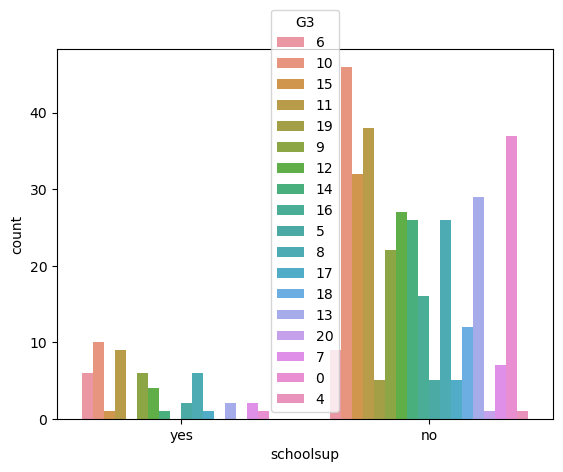

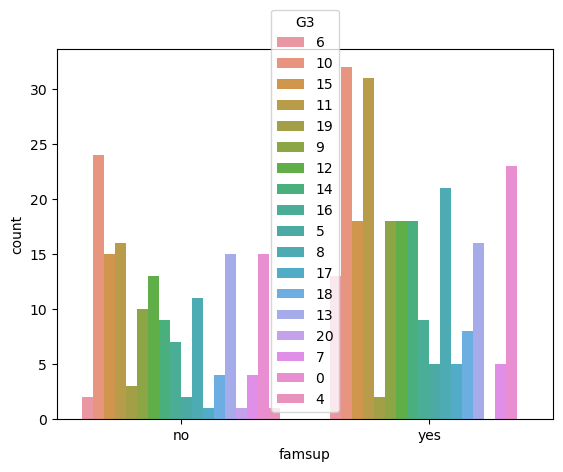

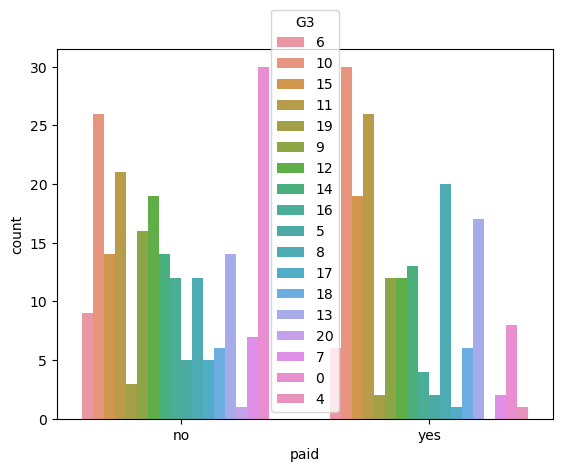

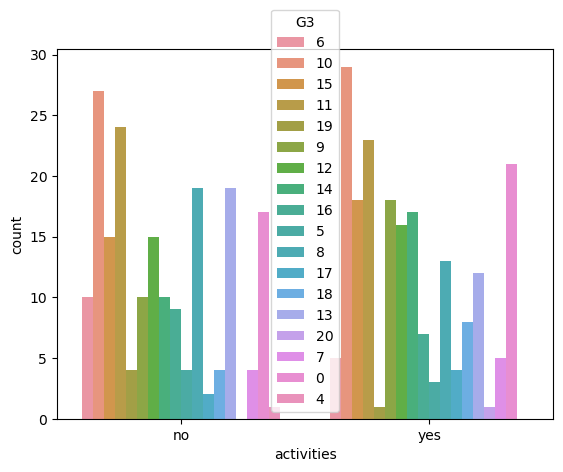

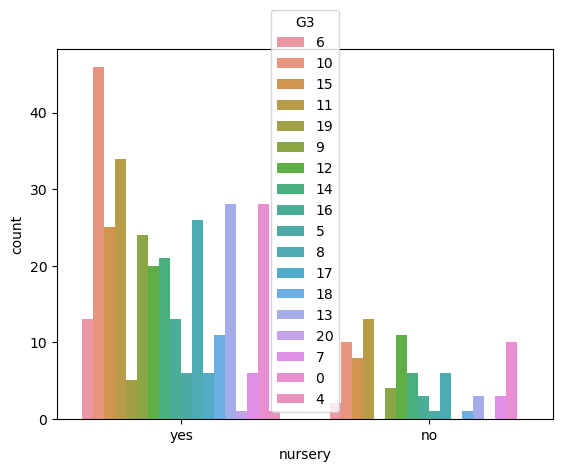

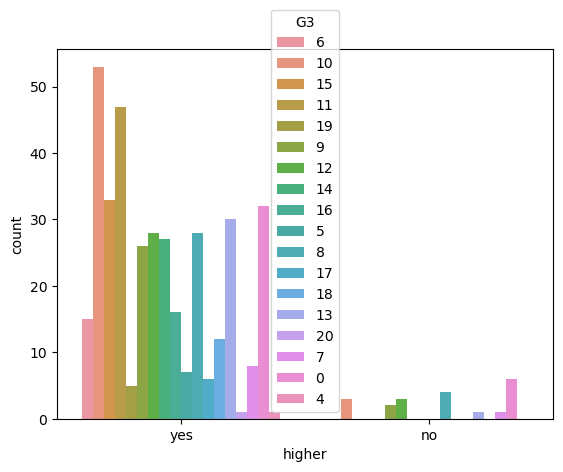

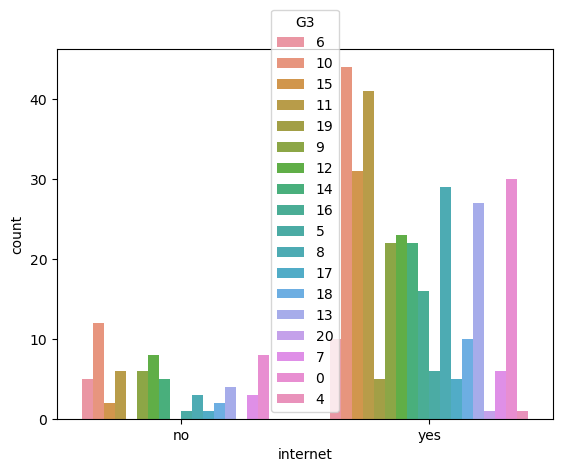

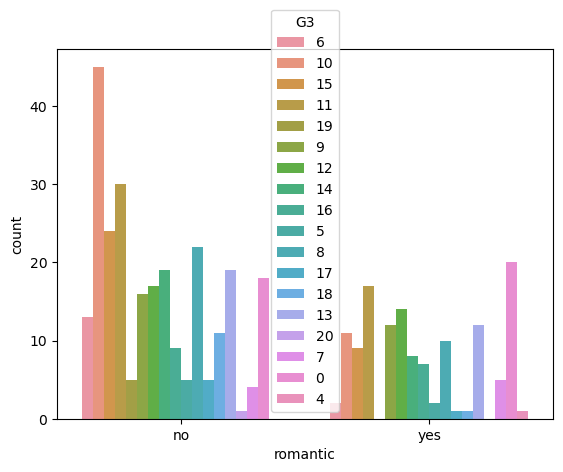

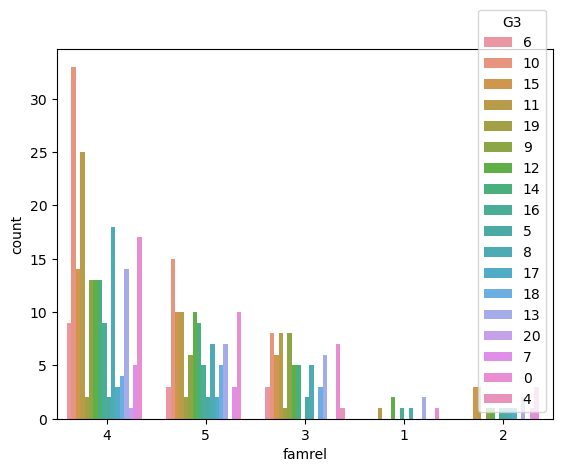

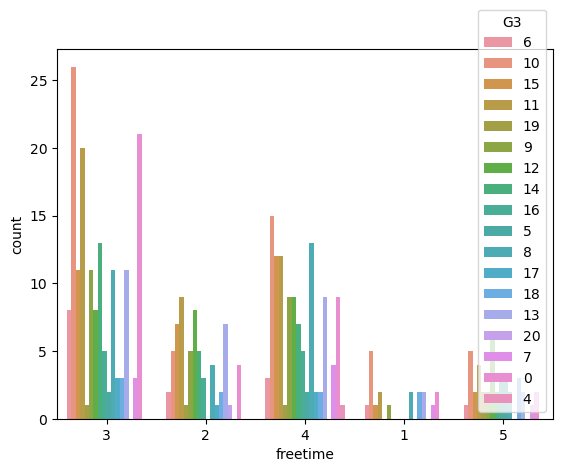

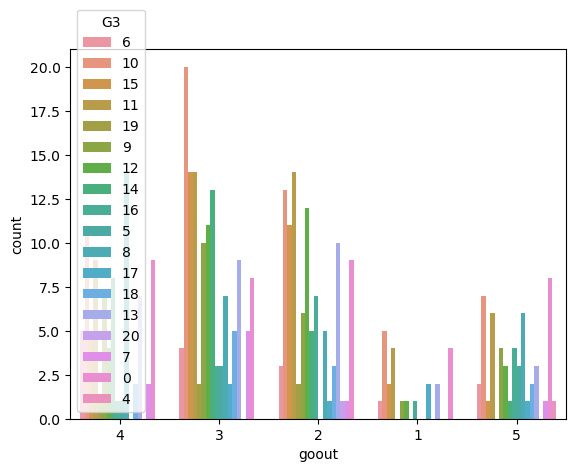

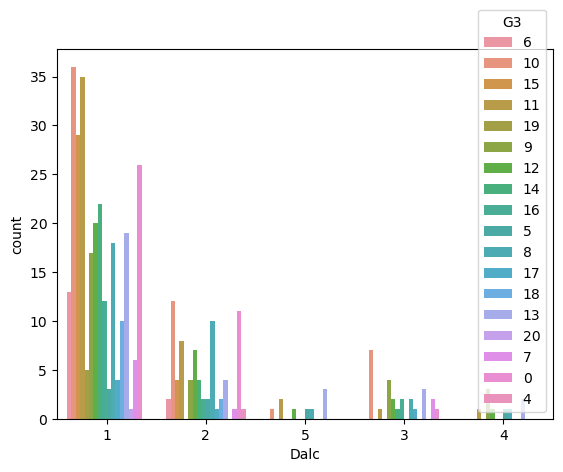

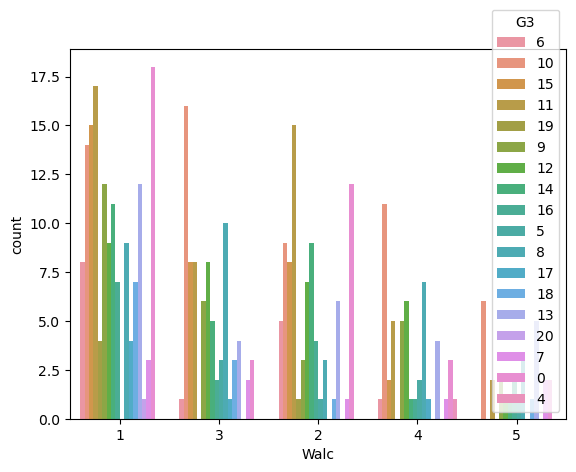

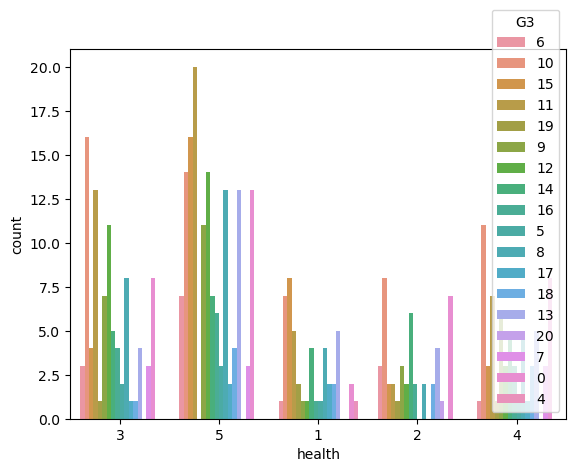

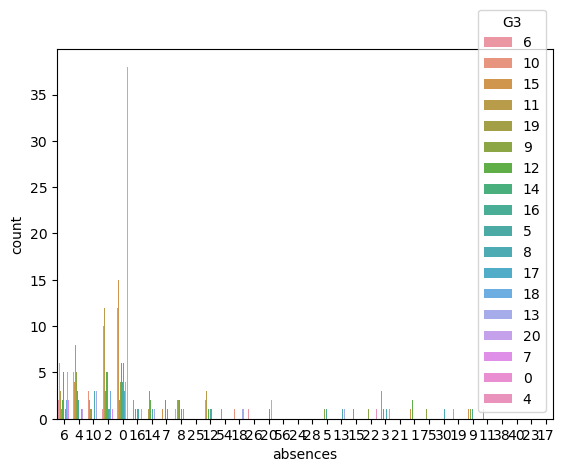

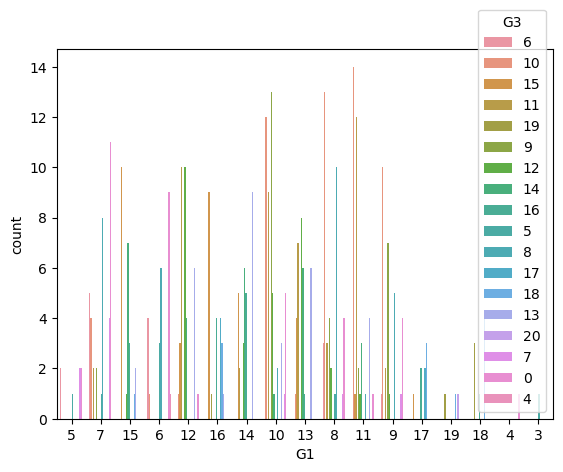

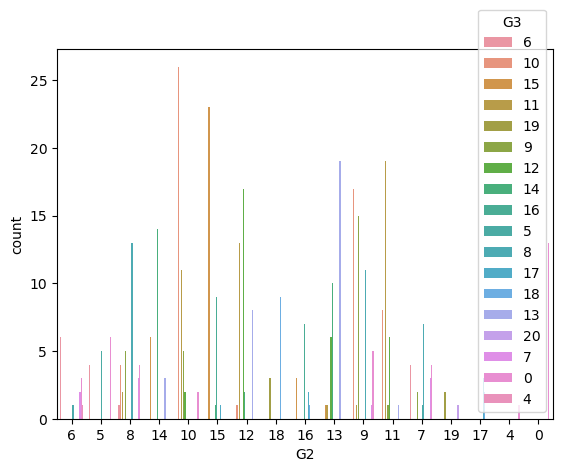

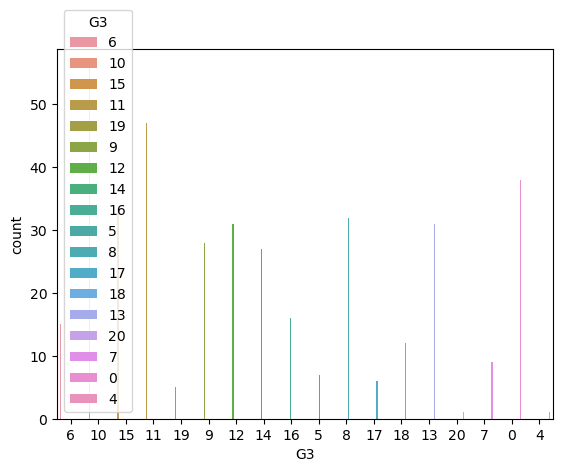

In [82]:
for column in df_mat.columns:
    sns.countplot(x=column, hue='G3', data=df_mat)
    plt.show()

## Normalize

In [83]:
columns = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2']

In [84]:
freq(df_por , columns)

La variable: school


,FA,FR,FAA,FRA
school,,,,
GP,423,0.651772,423,0.651772
MS,226,0.348228,649,1.000000




La variable: sex


,FA,FR,FAA,FRA
sex,,,,
F,383,0.590139,383,0.590139
M,266,0.409861,649,1.000000




La variable: age


,FA,FR,FAA,FRA
age,,,,
17,179,0.275809,179,0.275809
16,177,0.272727,356,0.548536
18,140,0.215716,496,0.764253
15,112,0.172573,608,0.936826
19,32,0.049307,640,0.986133
20,6,0.009245,646,0.995378
21,2,0.003082,648,0.998459
22,1,0.001541,649,1.000000




La variable: address


,FA,FR,FAA,FRA
address,,,,
U,452,0.696456,452,0.696456
R,197,0.303544,649,1.000000




La variable: famsize


,FA,FR,FAA,FRA
famsize,,,,
GT3,457,0.70416,457,0.70416
LE3,192,0.29584,649,1.00000




La variable: Pstatus


,FA,FR,FAA,FRA
Pstatus,,,,
T,569,0.876733,569,0.876733
A,80,0.123267,649,1.000000




La variable: Medu


,FA,FR,FAA,FRA
Medu,,,,
2,186,0.286595,186,0.286595
4,175,0.269646,361,0.556240
1,143,0.220339,504,0.776579
3,139,0.214176,643,0.990755
0,6,0.009245,649,1.000000




La variable: Fedu


,FA,FR,FAA,FRA
Fedu,,,,
2,209,0.322034,209,0.322034
1,174,0.268105,383,0.590139
3,131,0.201849,514,0.791988
4,128,0.197227,642,0.989214
0,7,0.010786,649,1.000000




La variable: Mjob


,FA,FR,FAA,FRA
Mjob,,,,
other,258,0.397535,258,0.397535
services,136,0.209553,394,0.607088
at_home,135,0.208012,529,0.815100
teacher,72,0.110940,601,0.926040
health,48,0.073960,649,1.000000




La variable: Fjob


,FA,FR,FAA,FRA
Fjob,,,,
other,367,0.565485,367,0.565485
services,181,0.278891,548,0.844376
at_home,42,0.064715,590,0.909091
teacher,36,0.055470,626,0.964561
health,23,0.035439,649,1.000000




La variable: reason


,FA,FR,FAA,FRA
reason,,,,
course,285,0.439137,285,0.439137
home,149,0.229584,434,0.668721
reputation,143,0.220339,577,0.889060
other,72,0.110940,649,1.000000




La variable: guardian


,FA,FR,FAA,FRA
guardian,,,,
mother,455,0.701079,455,0.701079
father,153,0.235747,608,0.936826
other,41,0.063174,649,1.000000




La variable: traveltime


,FA,FR,FAA,FRA
traveltime,,,,
1,366,0.563945,366,0.563945
2,213,0.328197,579,0.892142
3,54,0.083205,633,0.975347
4,16,0.024653,649,1.000000




La variable: studytime


,FA,FR,FAA,FRA
studytime,,,,
2,305,0.469954,305,0.469954
1,212,0.326656,517,0.796610
3,97,0.149461,614,0.946071
4,35,0.053929,649,1.000000




La variable: failures


,FA,FR,FAA,FRA
failures,,,,
0,549,0.845917,549,0.845917
1,70,0.107858,619,0.953775
2,16,0.024653,635,0.978428
3,14,0.021572,649,1.000000




La variable: schoolsup


,FA,FR,FAA,FRA
schoolsup,,,,
no,581,0.895223,581,0.895223
yes,68,0.104777,649,1.000000




La variable: famsup


,FA,FR,FAA,FRA
famsup,,,,
yes,398,0.613251,398,0.613251
no,251,0.386749,649,1.000000




La variable: paid


,FA,FR,FAA,FRA
paid,,,,
no,610,0.939908,610,0.939908
yes,39,0.060092,649,1.000000




La variable: activities


,FA,FR,FAA,FRA
activities,,,,
no,334,0.514638,334,0.514638
yes,315,0.485362,649,1.000000




La variable: nursery


,FA,FR,FAA,FRA
nursery,,,,
yes,521,0.802773,521,0.802773
no,128,0.197227,649,1.000000




La variable: higher


,FA,FR,FAA,FRA
higher,,,,
yes,580,0.893683,580,0.893683
no,69,0.106317,649,1.000000




La variable: internet


,FA,FR,FAA,FRA
internet,,,,
yes,498,0.767334,498,0.767334
no,151,0.232666,649,1.000000




La variable: romantic


,FA,FR,FAA,FRA
romantic,,,,
no,410,0.631741,410,0.631741
yes,239,0.368259,649,1.000000




La variable: famrel


,FA,FR,FAA,FRA
famrel,,,,
4,317,0.488444,317,0.488444
5,180,0.277350,497,0.765794
3,101,0.155624,598,0.921418
2,29,0.044684,627,0.966102
1,22,0.033898,649,1.000000




La variable: freetime


,FA,FR,FAA,FRA
freetime,,,,
3,251,0.386749,251,0.386749
4,178,0.274268,429,0.661017
2,107,0.164869,536,0.825886
5,68,0.104777,604,0.930663
1,45,0.069337,649,1.000000




La variable: goout


,FA,FR,FAA,FRA
goout,,,,
3,205,0.315871,205,0.315871
2,145,0.223421,350,0.539291
4,141,0.217257,491,0.756549
5,110,0.169492,601,0.926040
1,48,0.073960,649,1.000000




La variable: Dalc


,FA,FR,FAA,FRA
Dalc,,,,
1,451,0.694915,451,0.694915
2,121,0.186441,572,0.881356
3,43,0.066256,615,0.947612
5,17,0.026194,632,0.973806
4,17,0.026194,649,1.000000




La variable: Walc


,FA,FR,FAA,FRA
Walc,,,,
1,247,0.380586,247,0.380586
2,150,0.231125,397,0.611710
3,120,0.184900,517,0.796610
4,87,0.134052,604,0.930663
5,45,0.069337,649,1.000000




La variable: health


,FA,FR,FAA,FRA
health,,,,
5,249,0.383667,249,0.383667
3,124,0.191063,373,0.574730
4,108,0.166410,481,0.741140
1,90,0.138675,571,0.879815
2,78,0.120185,649,1.000000




La variable: absences


,FA,FR,FAA,FRA
absences,,,,
0,244,0.375963,244,0.375963
2,110,0.169492,354,0.545455
4,93,0.143297,447,0.688752
6,49,0.075501,496,0.764253
8,42,0.064715,538,0.828968
10,21,0.032357,559,0.861325
1,12,0.018490,571,0.879815
12,12,0.018490,583,0.898305
5,12,0.018490,595,0.916795




La variable: G1


,FA,FR,FAA,FRA
G1,,,,
10,95,0.146379,95,0.146379
11,91,0.140216,186,0.286595
12,82,0.126348,268,0.412943
13,72,0.110940,340,0.523883
14,71,0.109399,411,0.633282
9,65,0.100154,476,0.733436
8,42,0.064715,518,0.798151
15,35,0.053929,553,0.852080
7,33,0.050847,586,0.902928




La variable: G2


,FA,FR,FAA,FRA
G2,,,,
11,103,0.158706,103,0.158706
12,86,0.132512,189,0.291217
10,83,0.127889,272,0.419106
13,80,0.123267,352,0.542373
9,72,0.110940,424,0.653313
14,54,0.083205,478,0.736518
8,40,0.061633,518,0.798151
15,38,0.058552,556,0.856703
16,25,0.038521,581,0.895223


In [85]:
for col in columns:
    df_por = norm( df_por , col , 0.03)
varn_por = df_por.filter(like='n_').columns.tolist()

In [86]:
freq(df_por , varn_por)

La variable: n_school


,FA,FR,FAA,FRA
n_school,,,,
GP,423,0.651772,423,0.651772
MS,226,0.348228,649,1.000000




La variable: n_sex


,FA,FR,FAA,FRA
n_sex,,,,
F,383,0.590139,383,0.590139
M,266,0.409861,649,1.000000




La variable: n_age


,FA,FR,FAA,FRA
n_age,,,,
17,188,0.289676,188,0.289676
16,177,0.272727,365,0.562404
18,140,0.215716,505,0.778120
15,112,0.172573,617,0.950693
19,32,0.049307,649,1.000000




La variable: n_address


,FA,FR,FAA,FRA
n_address,,,,
U,452,0.696456,452,0.696456
R,197,0.303544,649,1.000000




La variable: n_famsize


,FA,FR,FAA,FRA
n_famsize,,,,
GT3,457,0.70416,457,0.70416
LE3,192,0.29584,649,1.00000




La variable: n_Pstatus


,FA,FR,FAA,FRA
n_Pstatus,,,,
T,569,0.876733,569,0.876733
A,80,0.123267,649,1.000000




La variable: n_Medu


,FA,FR,FAA,FRA
n_Medu,,,,
2,192,0.295840,192,0.295840
4,175,0.269646,367,0.565485
1,143,0.220339,510,0.785824
3,139,0.214176,649,1.000000




La variable: n_Fedu


,FA,FR,FAA,FRA
n_Fedu,,,,
2,216,0.332820,216,0.332820
1,174,0.268105,390,0.600924
3,131,0.201849,521,0.802773
4,128,0.197227,649,1.000000




La variable: n_Mjob


,FA,FR,FAA,FRA
n_Mjob,,,,
other,258,0.397535,258,0.397535
services,136,0.209553,394,0.607088
at_home,135,0.208012,529,0.815100
teacher,72,0.110940,601,0.926040
health,48,0.073960,649,1.000000




La variable: n_Fjob


,FA,FR,FAA,FRA
n_Fjob,,,,
other,367,0.565485,367,0.565485
services,181,0.278891,548,0.844376
at_home,42,0.064715,590,0.909091
teacher,36,0.055470,626,0.964561
health,23,0.035439,649,1.000000




La variable: n_reason


,FA,FR,FAA,FRA
n_reason,,,,
course,285,0.439137,285,0.439137
home,149,0.229584,434,0.668721
reputation,143,0.220339,577,0.889060
other,72,0.110940,649,1.000000




La variable: n_guardian


,FA,FR,FAA,FRA
n_guardian,,,,
mother,455,0.701079,455,0.701079
father,153,0.235747,608,0.936826
other,41,0.063174,649,1.000000




La variable: n_traveltime


,FA,FR,FAA,FRA
n_traveltime,,,,
1,382,0.588598,382,0.588598
2,213,0.328197,595,0.916795
3,54,0.083205,649,1.000000




La variable: n_studytime


,FA,FR,FAA,FRA
n_studytime,,,,
2,305,0.469954,305,0.469954
1,212,0.326656,517,0.796610
3,97,0.149461,614,0.946071
4,35,0.053929,649,1.000000




La variable: n_failures


,FA,FR,FAA,FRA
n_failures,,,,
0,549,0.845917,549,0.845917
1,70,0.107858,619,0.953775
SMALL_CAT,30,0.046225,649,1.000000




La variable: n_schoolsup


,FA,FR,FAA,FRA
n_schoolsup,,,,
no,581,0.895223,581,0.895223
yes,68,0.104777,649,1.000000




La variable: n_famsup


,FA,FR,FAA,FRA
n_famsup,,,,
yes,398,0.613251,398,0.613251
no,251,0.386749,649,1.000000




La variable: n_paid


,FA,FR,FAA,FRA
n_paid,,,,
no,610,0.939908,610,0.939908
yes,39,0.060092,649,1.000000




La variable: n_activities


,FA,FR,FAA,FRA
n_activities,,,,
no,334,0.514638,334,0.514638
yes,315,0.485362,649,1.000000




La variable: n_nursery


,FA,FR,FAA,FRA
n_nursery,,,,
yes,521,0.802773,521,0.802773
no,128,0.197227,649,1.000000




La variable: n_higher


,FA,FR,FAA,FRA
n_higher,,,,
yes,580,0.893683,580,0.893683
no,69,0.106317,649,1.000000




La variable: n_internet


,FA,FR,FAA,FRA
n_internet,,,,
yes,498,0.767334,498,0.767334
no,151,0.232666,649,1.000000




La variable: n_romantic


,FA,FR,FAA,FRA
n_romantic,,,,
no,410,0.631741,410,0.631741
yes,239,0.368259,649,1.000000




La variable: n_famrel


,FA,FR,FAA,FRA
n_famrel,,,,
4,317,0.488444,317,0.488444
5,180,0.277350,497,0.765794
3,101,0.155624,598,0.921418
2,29,0.044684,627,0.966102
1,22,0.033898,649,1.000000




La variable: n_freetime


,FA,FR,FAA,FRA
n_freetime,,,,
3,251,0.386749,251,0.386749
4,178,0.274268,429,0.661017
2,107,0.164869,536,0.825886
5,68,0.104777,604,0.930663
1,45,0.069337,649,1.000000




La variable: n_goout


,FA,FR,FAA,FRA
n_goout,,,,
3,205,0.315871,205,0.315871
2,145,0.223421,350,0.539291
4,141,0.217257,491,0.756549
5,110,0.169492,601,0.926040
1,48,0.073960,649,1.000000




La variable: n_Dalc


,FA,FR,FAA,FRA
n_Dalc,,,,
1,451,0.694915,451,0.694915
2,121,0.186441,572,0.881356
3,43,0.066256,615,0.947612
SMALL_CAT,34,0.052388,649,1.000000




La variable: n_Walc


,FA,FR,FAA,FRA
n_Walc,,,,
1,247,0.380586,247,0.380586
2,150,0.231125,397,0.611710
3,120,0.184900,517,0.796610
4,87,0.134052,604,0.930663
5,45,0.069337,649,1.000000




La variable: n_health


,FA,FR,FAA,FRA
n_health,,,,
5,249,0.383667,249,0.383667
3,124,0.191063,373,0.574730
4,108,0.166410,481,0.741140
1,90,0.138675,571,0.879815
2,78,0.120185,649,1.000000




La variable: n_absences


,FA,FR,FAA,FRA
n_absences,,,,
0,244,0.375963,244,0.375963
2,110,0.169492,354,0.545455
4,93,0.143297,447,0.688752
SMALL_CAT,90,0.138675,537,0.827427
6,49,0.075501,586,0.902928
8,42,0.064715,628,0.967643
10,21,0.032357,649,1.000000




La variable: n_G1


,FA,FR,FAA,FRA
n_G1,,,,
10,95,0.146379,95,0.146379
11,91,0.140216,186,0.286595
12,82,0.126348,268,0.412943
13,72,0.110940,340,0.523883
14,71,0.109399,411,0.633282
9,65,0.100154,476,0.733436
8,42,0.064715,518,0.798151
SMALL_CAT,41,0.063174,559,0.861325
15,35,0.053929,594,0.915254




La variable: n_G2


,FA,FR,FAA,FRA
n_G2,,,,
11,103,0.158706,103,0.158706
12,86,0.132512,189,0.291217
10,83,0.127889,272,0.419106
13,80,0.123267,352,0.542373
9,72,0.110940,424,0.653313
14,54,0.083205,478,0.736518
SMALL_CAT,48,0.073960,526,0.810478
8,40,0.061633,566,0.872111
15,38,0.058552,604,0.930663


In [87]:
freq(df_mat , columns)

La variable: school


,FA,FR,FAA,FRA
school,,,,
GP,349,0.883544,349,0.883544
MS,46,0.116456,395,1.000000




La variable: sex


,FA,FR,FAA,FRA
sex,,,,
F,208,0.526582,208,0.526582
M,187,0.473418,395,1.000000




La variable: age


,FA,FR,FAA,FRA
age,,,,
16,104,0.263291,104,0.263291
17,98,0.248101,202,0.511392
18,82,0.207595,284,0.718987
15,82,0.207595,366,0.926582
19,24,0.060759,390,0.987342
20,3,0.007595,393,0.994937
22,1,0.002532,394,0.997468
21,1,0.002532,395,1.000000




La variable: address


,FA,FR,FAA,FRA
address,,,,
U,307,0.777215,307,0.777215
R,88,0.222785,395,1.000000




La variable: famsize


,FA,FR,FAA,FRA
famsize,,,,
GT3,281,0.711392,281,0.711392
LE3,114,0.288608,395,1.000000




La variable: Pstatus


,FA,FR,FAA,FRA
Pstatus,,,,
T,354,0.896203,354,0.896203
A,41,0.103797,395,1.000000




La variable: Medu


,FA,FR,FAA,FRA
Medu,,,,
4,131,0.331646,131,0.331646
2,103,0.260759,234,0.592405
3,99,0.250633,333,0.843038
1,59,0.149367,392,0.992405
0,3,0.007595,395,1.000000




La variable: Fedu


,FA,FR,FAA,FRA
Fedu,,,,
2,115,0.291139,115,0.291139
3,100,0.253165,215,0.544304
4,96,0.243038,311,0.787342
1,82,0.207595,393,0.994937
0,2,0.005063,395,1.000000




La variable: Mjob


,FA,FR,FAA,FRA
Mjob,,,,
other,141,0.356962,141,0.356962
services,103,0.260759,244,0.617722
at_home,59,0.149367,303,0.767089
teacher,58,0.146835,361,0.913924
health,34,0.086076,395,1.000000




La variable: Fjob


,FA,FR,FAA,FRA
Fjob,,,,
other,217,0.549367,217,0.549367
services,111,0.281013,328,0.830380
teacher,29,0.073418,357,0.903797
at_home,20,0.050633,377,0.954430
health,18,0.045570,395,1.000000




La variable: reason


,FA,FR,FAA,FRA
reason,,,,
course,145,0.367089,145,0.367089
home,109,0.275949,254,0.643038
reputation,105,0.265823,359,0.908861
other,36,0.091139,395,1.000000




La variable: guardian


,FA,FR,FAA,FRA
guardian,,,,
mother,273,0.691139,273,0.691139
father,90,0.227848,363,0.918987
other,32,0.081013,395,1.000000




La variable: traveltime


,FA,FR,FAA,FRA
traveltime,,,,
1,257,0.650633,257,0.650633
2,107,0.270886,364,0.921519
3,23,0.058228,387,0.979747
4,8,0.020253,395,1.000000




La variable: studytime


,FA,FR,FAA,FRA
studytime,,,,
2,198,0.501266,198,0.501266
1,105,0.265823,303,0.767089
3,65,0.164557,368,0.931646
4,27,0.068354,395,1.000000




La variable: failures


,FA,FR,FAA,FRA
failures,,,,
0,312,0.789873,312,0.789873
1,50,0.126582,362,0.916456
2,17,0.043038,379,0.959494
3,16,0.040506,395,1.000000




La variable: schoolsup


,FA,FR,FAA,FRA
schoolsup,,,,
no,344,0.870886,344,0.870886
yes,51,0.129114,395,1.000000




La variable: famsup


,FA,FR,FAA,FRA
famsup,,,,
yes,242,0.612658,242,0.612658
no,153,0.387342,395,1.000000




La variable: paid


,FA,FR,FAA,FRA
paid,,,,
no,214,0.541772,214,0.541772
yes,181,0.458228,395,1.000000




La variable: activities


,FA,FR,FAA,FRA
activities,,,,
yes,201,0.508861,201,0.508861
no,194,0.491139,395,1.000000




La variable: nursery


,FA,FR,FAA,FRA
nursery,,,,
yes,314,0.794937,314,0.794937
no,81,0.205063,395,1.000000




La variable: higher


,FA,FR,FAA,FRA
higher,,,,
yes,375,0.949367,375,0.949367
no,20,0.050633,395,1.000000




La variable: internet


,FA,FR,FAA,FRA
internet,,,,
yes,329,0.832911,329,0.832911
no,66,0.167089,395,1.000000




La variable: romantic


,FA,FR,FAA,FRA
romantic,,,,
no,263,0.665823,263,0.665823
yes,132,0.334177,395,1.000000




La variable: famrel


,FA,FR,FAA,FRA
famrel,,,,
4,195,0.493671,195,0.493671
5,106,0.268354,301,0.762025
3,68,0.172152,369,0.934177
2,18,0.045570,387,0.979747
1,8,0.020253,395,1.000000




La variable: freetime


,FA,FR,FAA,FRA
freetime,,,,
3,157,0.397468,157,0.397468
4,115,0.291139,272,0.688608
2,64,0.162025,336,0.850633
5,40,0.101266,376,0.951899
1,19,0.048101,395,1.000000




La variable: goout


,FA,FR,FAA,FRA
goout,,,,
3,130,0.329114,130,0.329114
2,103,0.260759,233,0.589873
4,86,0.217722,319,0.807595
5,53,0.134177,372,0.941772
1,23,0.058228,395,1.000000




La variable: Dalc


,FA,FR,FAA,FRA
Dalc,,,,
1,276,0.698734,276,0.698734
2,75,0.189873,351,0.888608
3,26,0.065823,377,0.954430
5,9,0.022785,386,0.977215
4,9,0.022785,395,1.000000




La variable: Walc


,FA,FR,FAA,FRA
Walc,,,,
1,151,0.382278,151,0.382278
2,85,0.215190,236,0.597468
3,80,0.202532,316,0.800000
4,51,0.129114,367,0.929114
5,28,0.070886,395,1.000000




La variable: health


,FA,FR,FAA,FRA
health,,,,
5,146,0.369620,146,0.369620
3,91,0.230380,237,0.600000
4,66,0.167089,303,0.767089
1,47,0.118987,350,0.886076
2,45,0.113924,395,1.000000




La variable: absences


,FA,FR,FAA,FRA
absences,,,,
0,115,0.291139,115,0.291139
2,65,0.164557,180,0.455696
4,53,0.134177,233,0.589873
6,31,0.078481,264,0.668354
8,22,0.055696,286,0.724051
10,17,0.043038,303,0.767089
14,12,0.030380,315,0.797468
12,12,0.030380,327,0.827848
3,8,0.020253,335,0.848101




La variable: G1


,FA,FR,FAA,FRA
G1,,,,
10,51,0.129114,51,0.129114
8,41,0.103797,92,0.232911
11,39,0.098734,131,0.331646
7,37,0.093671,168,0.425316
12,35,0.088608,203,0.513924
13,33,0.083544,236,0.597468
9,31,0.078481,267,0.675949
14,30,0.075949,297,0.751899
15,24,0.060759,321,0.812658




La variable: G2


,FA,FR,FAA,FRA
G2,,,,
9,50,0.126582,50,0.126582
10,46,0.116456,96,0.243038
12,41,0.103797,137,0.346835
13,37,0.093671,174,0.440506
11,35,0.088608,209,0.529114
15,34,0.086076,243,0.615190
8,32,0.081013,275,0.696203
14,23,0.058228,298,0.754430
7,21,0.053165,319,0.807595


In [88]:
for col in columns:
    df_mat = norm( df_mat , col , 0.03)
varn_mat = df_mat.filter(like='n_').columns.tolist()

In [89]:
freq(df_mat , varn_mat)

La variable: n_school


,FA,FR,FAA,FRA
n_school,,,,
GP,349,0.883544,349,0.883544
MS,46,0.116456,395,1.000000




La variable: n_sex


,FA,FR,FAA,FRA
n_sex,,,,
F,208,0.526582,208,0.526582
M,187,0.473418,395,1.000000




La variable: n_age


,FA,FR,FAA,FRA
n_age,,,,
16,109,0.275949,109,0.275949
17,98,0.248101,207,0.524051
18,82,0.207595,289,0.731646
15,82,0.207595,371,0.939241
19,24,0.060759,395,1.000000




La variable: n_address


,FA,FR,FAA,FRA
n_address,,,,
U,307,0.777215,307,0.777215
R,88,0.222785,395,1.000000




La variable: n_famsize


,FA,FR,FAA,FRA
n_famsize,,,,
GT3,281,0.711392,281,0.711392
LE3,114,0.288608,395,1.000000




La variable: n_Pstatus


,FA,FR,FAA,FRA
n_Pstatus,,,,
T,354,0.896203,354,0.896203
A,41,0.103797,395,1.000000




La variable: n_Medu


,FA,FR,FAA,FRA
n_Medu,,,,
4,134,0.339241,134,0.339241
2,103,0.260759,237,0.600000
3,99,0.250633,336,0.850633
1,59,0.149367,395,1.000000




La variable: n_Fedu


,FA,FR,FAA,FRA
n_Fedu,,,,
2,117,0.296203,117,0.296203
3,100,0.253165,217,0.549367
4,96,0.243038,313,0.792405
1,82,0.207595,395,1.000000




La variable: n_Mjob


,FA,FR,FAA,FRA
n_Mjob,,,,
other,141,0.356962,141,0.356962
services,103,0.260759,244,0.617722
at_home,59,0.149367,303,0.767089
teacher,58,0.146835,361,0.913924
health,34,0.086076,395,1.000000




La variable: n_Fjob


,FA,FR,FAA,FRA
n_Fjob,,,,
other,217,0.549367,217,0.549367
services,111,0.281013,328,0.830380
teacher,29,0.073418,357,0.903797
at_home,20,0.050633,377,0.954430
health,18,0.045570,395,1.000000




La variable: n_reason


,FA,FR,FAA,FRA
n_reason,,,,
course,145,0.367089,145,0.367089
home,109,0.275949,254,0.643038
reputation,105,0.265823,359,0.908861
other,36,0.091139,395,1.000000




La variable: n_guardian


,FA,FR,FAA,FRA
n_guardian,,,,
mother,273,0.691139,273,0.691139
father,90,0.227848,363,0.918987
other,32,0.081013,395,1.000000




La variable: n_traveltime


,FA,FR,FAA,FRA
n_traveltime,,,,
1,265,0.670886,265,0.670886
2,107,0.270886,372,0.941772
3,23,0.058228,395,1.000000




La variable: n_studytime


,FA,FR,FAA,FRA
n_studytime,,,,
2,198,0.501266,198,0.501266
1,105,0.265823,303,0.767089
3,65,0.164557,368,0.931646
4,27,0.068354,395,1.000000




La variable: n_failures


,FA,FR,FAA,FRA
n_failures,,,,
0,312,0.789873,312,0.789873
1,50,0.126582,362,0.916456
2,17,0.043038,379,0.959494
3,16,0.040506,395,1.000000




La variable: n_schoolsup


,FA,FR,FAA,FRA
n_schoolsup,,,,
no,344,0.870886,344,0.870886
yes,51,0.129114,395,1.000000




La variable: n_famsup


,FA,FR,FAA,FRA
n_famsup,,,,
yes,242,0.612658,242,0.612658
no,153,0.387342,395,1.000000




La variable: n_paid


,FA,FR,FAA,FRA
n_paid,,,,
no,214,0.541772,214,0.541772
yes,181,0.458228,395,1.000000




La variable: n_activities


,FA,FR,FAA,FRA
n_activities,,,,
yes,201,0.508861,201,0.508861
no,194,0.491139,395,1.000000




La variable: n_nursery


,FA,FR,FAA,FRA
n_nursery,,,,
yes,314,0.794937,314,0.794937
no,81,0.205063,395,1.000000




La variable: n_higher


,FA,FR,FAA,FRA
n_higher,,,,
yes,375,0.949367,375,0.949367
no,20,0.050633,395,1.000000




La variable: n_internet


,FA,FR,FAA,FRA
n_internet,,,,
yes,329,0.832911,329,0.832911
no,66,0.167089,395,1.000000




La variable: n_romantic


,FA,FR,FAA,FRA
n_romantic,,,,
no,263,0.665823,263,0.665823
yes,132,0.334177,395,1.000000




La variable: n_famrel


,FA,FR,FAA,FRA
n_famrel,,,,
4,203,0.513924,203,0.513924
5,106,0.268354,309,0.782278
3,68,0.172152,377,0.954430
2,18,0.045570,395,1.000000




La variable: n_freetime


,FA,FR,FAA,FRA
n_freetime,,,,
3,157,0.397468,157,0.397468
4,115,0.291139,272,0.688608
2,64,0.162025,336,0.850633
5,40,0.101266,376,0.951899
1,19,0.048101,395,1.000000




La variable: n_goout


,FA,FR,FAA,FRA
n_goout,,,,
3,130,0.329114,130,0.329114
2,103,0.260759,233,0.589873
4,86,0.217722,319,0.807595
5,53,0.134177,372,0.941772
1,23,0.058228,395,1.000000




La variable: n_Dalc


,FA,FR,FAA,FRA
n_Dalc,,,,
1,276,0.698734,276,0.698734
2,75,0.189873,351,0.888608
3,26,0.065823,377,0.954430
SMALL_CAT,18,0.045570,395,1.000000




La variable: n_Walc


,FA,FR,FAA,FRA
n_Walc,,,,
1,151,0.382278,151,0.382278
2,85,0.215190,236,0.597468
3,80,0.202532,316,0.800000
4,51,0.129114,367,0.929114
5,28,0.070886,395,1.000000




La variable: n_health


,FA,FR,FAA,FRA
n_health,,,,
5,146,0.369620,146,0.369620
3,91,0.230380,237,0.600000
4,66,0.167089,303,0.767089
1,47,0.118987,350,0.886076
2,45,0.113924,395,1.000000




La variable: n_absences


,FA,FR,FAA,FRA
n_absences,,,,
0,115,0.291139,115,0.291139
SMALL_CAT,68,0.172152,183,0.463291
2,65,0.164557,248,0.627848
4,53,0.134177,301,0.762025
6,31,0.078481,332,0.840506
8,22,0.055696,354,0.896203
10,17,0.043038,371,0.939241
14,12,0.030380,383,0.969620
12,12,0.030380,395,1.000000




La variable: n_G1


,FA,FR,FAA,FRA
n_G1,,,,
10,51,0.129114,51,0.129114
8,41,0.103797,92,0.232911
11,39,0.098734,131,0.331646
7,37,0.093671,168,0.425316
12,35,0.088608,203,0.513924
13,33,0.083544,236,0.597468
9,31,0.078481,267,0.675949
14,30,0.075949,297,0.751899
SMALL_CAT,28,0.070886,325,0.822785




La variable: n_G2


,FA,FR,FAA,FRA
n_G2,,,,
9,59,0.149367,59,0.149367
10,46,0.116456,105,0.265823
12,41,0.103797,146,0.369620
13,37,0.093671,183,0.463291
11,35,0.088608,218,0.551899
15,34,0.086076,252,0.637975
8,32,0.081013,284,0.718987
14,23,0.058228,307,0.777215
7,21,0.053165,328,0.830380


In [97]:
unarias = [ v for v, conteo in zip( varn_por , [ df_por[v].unique().shape[0] for v in varn_por ] ) if conteo == 1 ]

In [98]:
unarias

[]

In [99]:
unarias = [ v for v, conteo in zip( varn_mat , [ df_mat[v].unique().shape[0] for v in varn_mat ] ) if conteo == 1 ]

In [100]:
unarias

[]

# Feature Engineering

In [101]:
binarian_cols = ['n_schoolsup', 'n_famsup', 'n_paid', 'n_activities', 'n_nursery', 'n_higher', 'n_internet', 'n_romantic']
df_mat[binarian_cols] = df_mat[binarian_cols].replace({'yes': 1, 'no': 0})

In [103]:
encoder_columns = ['n_school', 'n_sex',
       'n_age', 'n_address', 'n_famsize', 'n_Pstatus', 'n_Medu', 'n_Fedu',
       'n_Mjob', 'n_Fjob', 'n_reason', 'n_guardian', 'n_traveltime',
       'n_studytime', 'n_failures', 
       'n_famrel', 'n_freetime', 'n_goout', 'n_Dalc', 'n_Walc', 'n_health',
       'n_absences', 'n_G1', 'n_G2']
encoder = OneHotEncoder(sparse=False, drop='first')

In [104]:
for col in encoder_columns:
    encoded = encoder.fit_transform(df_mat[[col]])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]), index=df_mat.index)
    df_mat = df_mat.drop(columns=[col])
    df_mat = pd.concat([df_mat, encoded_df], axis=1)

C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. 

In [105]:
df_mat.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,n_schoolsup,n_famsup,n_paid,n_activities,n_nursery,n_higher,n_internet,n_romantic,n_school_MS,n_sex_M,n_age_16,n_age_17,n_age_18,n_age_19,n_address_U,n_famsize_LE3,n_Pstatus_T,n_Medu_2,n_Medu_3,n_Medu_4,n_Fedu_2,n_Fedu_3,n_Fedu_4,n_Mjob_health,n_Mjob_other,n_Mjob_services,n_Mjob_teacher,n_Fjob_health,n_Fjob_other,n_Fjob_services,n_Fjob_teacher,n_reason_home,n_reason_other,n_reason_reputation,n_guardian_mother,n_guardian_other,n_traveltime_2,n_traveltime_3,n_studytime_2,n_studytime_3,n_studytime_4,n_failures_1,n_failures_2,n_failures_3,n_famrel_3,n_famrel_4,n_famrel_5,n_freetime_2,n_freetime_3,n_freetime_4,n_freetime_5,n_goout_2,n_goout_3,n_goout_4,n_goout_5,n_Dalc_2,n_Dalc_3,n_Dalc_SMALL_CAT,n_Walc_2,n_Walc_3,n_Walc_4,n_Walc_5,n_health_2,n_health_3,n_health_4,n_health_5,n_absences_10,n_absences_12,n_absences_14,n_absences_2,n_absences_4,n_absences_6,n_absences_8,n_absences_SMALL_CAT,n_G1_11,n_G1_12,n_G1_13,n_G1_14,n_G1_15,n_G1_16,n_G1_6,n_G1_7,n_G1_8,n_G1_9,n_G1_SMALL_CAT,n_G2_10,n_G2_11,n_G2_12,n_G2_13,n_G2_14,n_G2_15,n_G2_16,n_G2_18,n_G2_5,n_G2_6,n_G2_7,n_G2_8,n_G2_9
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,6,1,0,0,0,1,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,GP,F,15,R,GT3,T,1,1,other,other,reputation,mother,1,2,2,1,1,0,0,0,1,1,1,3,3,4,2,4,5,2,8,6,5,1,1,0,0,0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,GP,M,16,U,LE3,A,4,4,teacher,health,reputation,mother,1,2,0,0,1,0,0,1,1,0,0,4,1,3,3,5,5,18,8,6,7,0,1,0,0,1,1,0,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,GP,F,17,R,GT3,T,2,1,at_home,services,reputation,mother,2,2,0,0,1,0,1,1,1,1,0,4,2,5,1,2,5,2,6,6,6,0,1,0,1,1,1,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,GP,F,17,U,GT3,T,4,3,other,other,reputation,mother,1,2,2,0,0,1,0,1,1,1,1,3,4,5,2,4,1,22,6,6,4,0,0,1,0,1,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [106]:
df_por[binarian_cols] = df_por[binarian_cols].replace({'yes': 1, 'no': 0})

In [107]:
for col in encoder_columns:
    encoded = encoder.fit_transform(df_por[[col]])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]), index=df_por.index)
    df_por = df_por.drop(columns=[col])
    df_por = pd.concat([df_por, encoded_df], axis=1)

C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. 

In [108]:
df_por.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,n_schoolsup,n_famsup,n_paid,n_activities,n_nursery,n_higher,n_internet,n_romantic,n_school_MS,n_sex_M,n_age_16,n_age_17,n_age_18,n_age_19,n_address_U,n_famsize_LE3,n_Pstatus_T,n_Medu_2,n_Medu_3,n_Medu_4,n_Fedu_2,n_Fedu_3,n_Fedu_4,n_Mjob_health,n_Mjob_other,n_Mjob_services,n_Mjob_teacher,n_Fjob_health,n_Fjob_other,n_Fjob_services,n_Fjob_teacher,n_reason_home,n_reason_other,n_reason_reputation,n_guardian_mother,n_guardian_other,n_traveltime_2,n_traveltime_3,n_studytime_2,n_studytime_3,n_studytime_4,n_failures_1,n_failures_SMALL_CAT,n_famrel_2,n_famrel_3,n_famrel_4,n_famrel_5,n_freetime_2,n_freetime_3,n_freetime_4,n_freetime_5,n_goout_2,n_goout_3,n_goout_4,n_goout_5,n_Dalc_2,n_Dalc_3,n_Dalc_SMALL_CAT,n_Walc_2,n_Walc_3,n_Walc_4,n_Walc_5,n_health_2,n_health_3,n_health_4,n_health_5,n_absences_10,n_absences_2,n_absences_4,n_absences_6,n_absences_8,n_absences_SMALL_CAT,n_G1_11,n_G1_12,n_G1_13,n_G1_14,n_G1_15,n_G1_16,n_G1_7,n_G1_8,n_G1_9,n_G1_SMALL_CAT,n_G2_11,n_G2_12,n_G2_13,n_G2_14,n_G2_15,n_G2_16,n_G2_17,n_G2_8,n_G2_9,n_G2_SMALL_CAT
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11,1,0,0,0,1,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GP,M,19,U,GT3,T,2,1,other,other,reputation,mother,1,1,0,no,no,no,no,yes,yes,yes,no,5,3,4,1,4,4,10,7,11,11,0,0,0,0,1,1,1,0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MS,F,15,R,LE3,T,2,2,other,other,other,father,1,3,0,yes,yes,no,no,yes,yes,no,no,4,4,3,2,2,5,2,14,11,12,1,1,0,0,1,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MS,M,17,R,LE3,T,1,2,at_home,services,reputation,mother,1,1,0,no,yes,no,yes,yes,yes,yes,no,5,5,5,5,5,3,4,10,11,11,0,1,0,1,1,1,1,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,GP,F,16,U,LE3,T,1,1,at_home,at_home,course,mother,1,1,0,no,no,no,no,yes,yes,yes,no,3,4,4,3,3,1,4,10,11,11,0,0,0,0,1,1,1,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model

In [171]:
class_counts = df_mat['G3'].value_counts()
rare_classes = class_counts[class_counts < 2].index.tolist()
df_mat = df_mat[~df_mat['G3'].isin(rare_classes)]
X_mat = df_mat.filter(regex='^n_')
y_mat = df_mat['G3']
class_counts = df_por['G3'].value_counts()
rare_classes = class_counts[class_counts < 2].index.tolist()
df_por = df_por[~df_por['G3'].isin(rare_classes)]
X_por = df_por.filter(regex='^n_')
y_por = df_por['G3']

## Mat

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X_mat, y_mat, test_size=0.3, random_state=42)

In [173]:
param_grid = {
    'n_estimators': [10, 20, 30, 40,  50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Mejores hiperparámetros: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 40}


In [174]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [175]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.4067796610169492


In [176]:
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

Confusion Matrix:
[[9 2 0 0 0 0 0 0 0 0 0 0 0 0 3 1]
 [0 7 1 0 0 0 0 0 0 0 0 0 0 0 2 3]
 [0 2 6 5 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 3 3 1 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 2 4 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 3 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 3 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [3 0 0 0 0 0 0 0 0 0 0 1 2 0 3 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 6 1]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0 4 2]]


In [177]:
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
          10       0.44      0.54      0.48        13
          11       0.55      0.43      0.48        14
          12       0.30      0.30      0.30        10
          13       0.50      0.25      0.33         8
          14       0.25      0.60      0.35         5
          15       0.50      0.38      0.43         8
          16       0.50      0.40      0.44         5
          17       0.00      0.00      0.00         2
          18       0.50      0.75      0.60         4
          19       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2
           6       1.00      0.22      0.36         9
           7       0.00      0.00      0.00         3
           8       0.26      0.75      0.39         8
           9       0.22      0.22      0.22         9

    accuracy                           0.41       118
   

C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [184]:
roc_auc_score(y_true=y_test, y_score=best_model.predict_proba(X_test), multi_class='ovr')

0.868930683072678

In [ ]:
roc_auc_score(y_true=y_test, y_score=best_model.predict_proba(X_test), multi_class='ovo')

## Por

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X_por, y_por, test_size=0.3, random_state=42, stratify=y_por)

In [186]:
param_grid = {
    'n_estimators': [10, 20, 30, 40,  50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Mejores hiperparámetros: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 40}


In [187]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [188]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.47692307692307695


In [189]:
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

Confusion Matrix:
[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  3  0]
 [ 0 18  8  0  1  0  0  0  0  0  0  0  0  2  0]
 [ 0  6 22  2  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  7  4 11  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  4 18  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  3  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  2 11  0  1  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  3  7  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  2  2  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  1  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 2  4  0  0  0  0  0  0  0  0  0  0  0  3  1]
 [ 0  7  1  0  0  0  0  0  0  0  0  0  0  2  1]]


In [190]:
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.25      0.25         4
          10       0.47      0.62      0.54        29
          11       0.56      0.71      0.63        31
          12       0.36      0.18      0.24        22
          13       0.40      0.72      0.51        25
          14       0.38      0.16      0.22        19
          15       0.61      0.73      0.67        15
          16       0.78      0.64      0.70        11
          17       0.57      0.44      0.50         9
          18       0.50      0.25      0.33         4
          19       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         3
           8       0.25      0.30      0.27        10
           9       0.50      0.09      0.15        11

    accuracy                           0.48       195
   macro avg       0.38      0.34      0.33       195
wei

C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shumi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [192]:
roc_auc_score(y_true=y_test, y_score=best_model.predict_proba(X_test), multi_class='ovr')

0.9267082532307359

In [193]:
roc_auc_score(y_true=y_test, y_score=best_model.predict_proba(X_test), multi_class='ovo')

0.9065335812299186